In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import ChainMap
from scipy.integrate import cumtrapz, trapz
import re
import importlib
import seaborn as sns
sns.set()

%matplotlib inline

In [6]:
# local modules
from fastsim import simdrivehot, simdrive, vehicle, cycle, params, utils
import hot_utilities as hot_utils
importlib.reload(hot_utils)
# importlib.reload(simdrive)
# importlib.reload(cycle)

<module 'hot_utilities' from 'C:\\Users\\cbaker2\\Documents\\GitHub\\fastsim\\docs\\hot_utilities.py'>

In [21]:
t0 = time.time()
veh = vehicle.Vehicle(veh_file=
                          Path('../vehdb/2017 Toyota Highlander 3.5 L.csv'))
# dyno data does not warrant altitude correction
veh.vehKg = 4750 / 2.205
dragCoef, wheelRrCoef = utils.abc_to_drag_coeffs(veh.vehKg, veh.frontalAreaM2, 
                                                 30.56, 0.3690, 0.0251)
veh.dragCoef, veh.wheelRrCoef = dragCoef, wheelRrCoef
veh_jit = veh.get_numba_veh()

print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 6.633e-02 s


In [ ]:
fuel_HV_btu__lb = 18_547 # source: C:\Users\cbaker2\Documents\TestData\Highlander Conventional\TestSummary
fuel_rho_kg__l = 0.74 # not being used currently
fuel_HV_kj__kg = fuel_HV_btu__lb * 1.055 * 2.205 

In [33]:
t0 = time.time()
cyc_df = pd.read_csv(Path(
    'C:/Users/cbaker2/Documents/TestData/Highlander Conventional/' + 
    '10Hz/61810084 Test Data.txt'), sep='\t')
cyc_df['Fuel_Power_Calc[kW]'] = cyc_df['Eng_FuelFlow_Direct2[gps]'] / 1_000 * fuel_HV_kj__kg
cyc_df['Dyno_Spd[mps]'] = cyc_df['Dyno_Spd[mph]'].values / params.mphPerMps
print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 2.513e-01 s


In [35]:
t0 = time.time()
cyc = cycle.Cycle(cyc_dict={'cycSecs':cyc_df['Time[s]'].values, 
                            'cycMps':cyc_df['Dyno_Spd[mps]'].values,})
cyc_jit = cyc.get_numba_cyc()
print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 9.978e-04 s


In [36]:
t0 = time.time()
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
sim_drive.sim_drive()
print(f'Elapsed time: {time.time() - t0:.3e} s')

Elapsed time: 5.385e-02 s


Model uses 0.59% less fuel than test.


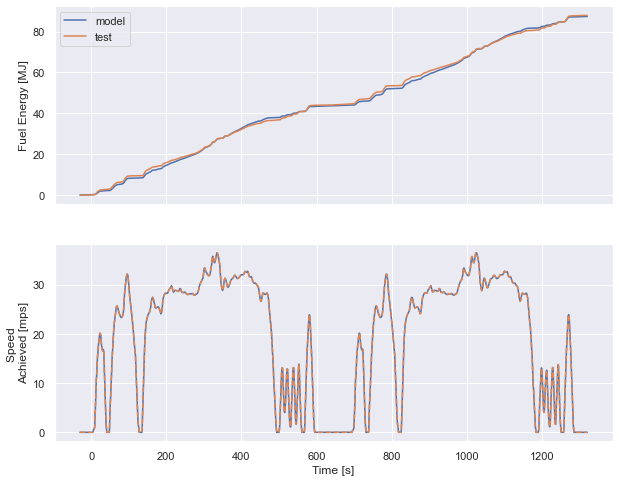

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs[1:], cumtrapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch * 1e-3), 
         label='model')
ax1.plot(cyc_df['Time[s]'][1:], cumtrapz(x=cyc_df['Time[s]'], y=cyc_df['Fuel_Power_Calc[kW]'] * 1e-3), 
         label='test')
ax1.set_ylabel('Fuel Energy [MJ]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(cyc_df['Time[s]'], 
         cyc_df['Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=cyc_df['Time[s]'], 
                         y=cyc_df['Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=cyc_df['Time[s]'], 
                         y=cyc_df['Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

In [ ]:
cyc_ids = {'62002026':'UDDSx2, CS, -7C, HVAC off',
          '61810082':'UDDSx2, CS, 25C, HVAC off',
          '618100024':'US06x2, HS, -7C, HVAC off',}
#           '62002042':'-2C Data:  UDDSx2 + US06x1, 72F set',
#           '62003016':'-2C Data:  UDDSx2 + US06x1, 72F set',}

In [ ]:
# load a list of dfs for cycles
# separate out the hs and cs ones
# rename/move variables as needed for fastsim
# create bonus variables (e.g. cumulative PKED)
# Feed it into a cycle object, and make the jit version

